In [1]:
pwd

'/home/gdolle/code/G-Dolle/DIVVY_BIKE/notebooks'

In [2]:
pwd
cd '/home/gdolle/code/G-Dolle/DIVVY_BIKE'

/home/gdolle/code/G-Dolle/DIVVY_BIKE


In [3]:
from divvy.ml_logic.data_import import get_station_data
import matplotlib.pyplot as plt 
import seaborn as sns

In [4]:
station_df = get_station_data()

In [5]:
station_df.head(2)

,Unnamed: 0,external_id,station_id,short_name,eightd_has_key_dispenser,legacy_id,electric_bike_surcharge_waiver,capacity,has_kiosk,rental_methods,...,station_type,eightd_station_services,region_id,region_code,address,dockless_bikes_parking_zone_capacity,rack_model,client_station_id,target_bike_capacity,target_scooter_capacity
0,0,a3b1c47b-a135-11e9-9cda-0a87ae2ba916,a3b1c47b-a135-11e9-9cda-0a87ae2ba916,16915,False,541,False,11,True,"['KEY', 'CREDITCARD', 'TRANSITCARD']",...,classic,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,a3b2d2b7-a135-11e9-9cda-0a87ae2ba916,a3b2d2b7-a135-11e9-9cda-0a87ae2ba916,593,False,593,False,11,True,"['KEY', 'CREDITCARD', 'TRANSITCARD']",...,classic,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
condition = station_df.capacity > 10

In [25]:
station_df = station_df[condition]

In [26]:
station_df.capacity.value_counts()

15    269
11    175
19     97
23     49
27     24
31     19
39     11
35      6
12      6
47      4
43      4
55      3
16      3
20      2
51      1
32      1
Name: capacity, dtype: int64

In [27]:
station_df_red = station_df[["lat","lon"]]

In [28]:
from folium import Map, plugins

m = Map([41.8781, -87.6298], zoom_start=8)

# convert to (n, 2) nd-array format for heatmap
stationArr = station_df_red.values

# plot heatmap
m.add_child(plugins.HeatMap(stationArr, radius=11))

<AxesSubplot: xlabel='lon', ylabel='lat'>

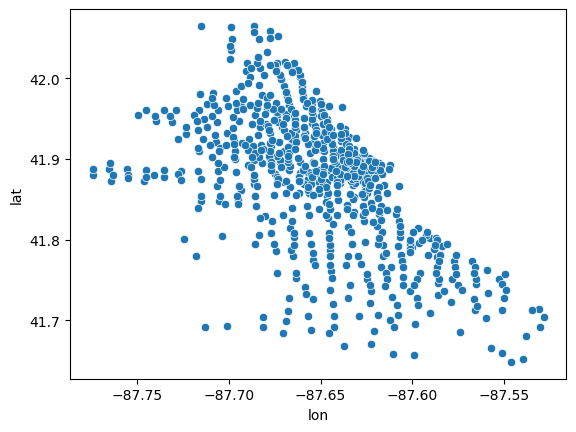

In [29]:
sns.scatterplot(x=station_df["lon"],y=station_df["lat"])

<AxesSubplot: xlabel='lon', ylabel='lat'>

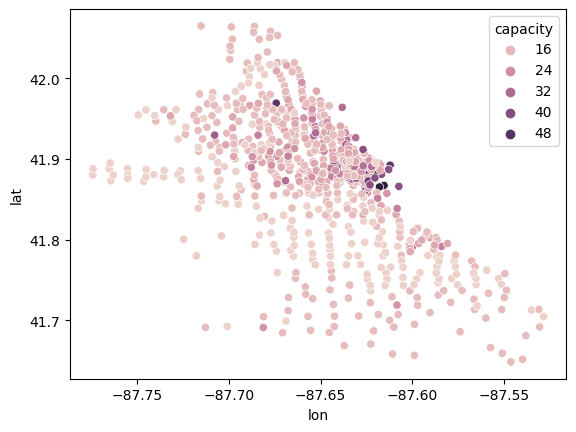

In [30]:
sns.scatterplot(x=station_df["lon"],y=station_df["lat"], hue=station_df["capacity"])

In [31]:
import pygeohash as gh

In [33]:
station_df["geohash"] = station_df.apply(lambda x: gh.encode(x.lat,
                                                                x.lon,
                                                                precision=4),
                                            axis=1)

In [46]:
print(station_df["lat"].min())
print(station_df["lon"].min())



41.64850076266409
-87.774453


In [47]:
print(station_df["lat"].max())
print(station_df["lon"].max())


42.064854
-87.52823173999786


<AxesSubplot: xlabel='lon', ylabel='lat'>

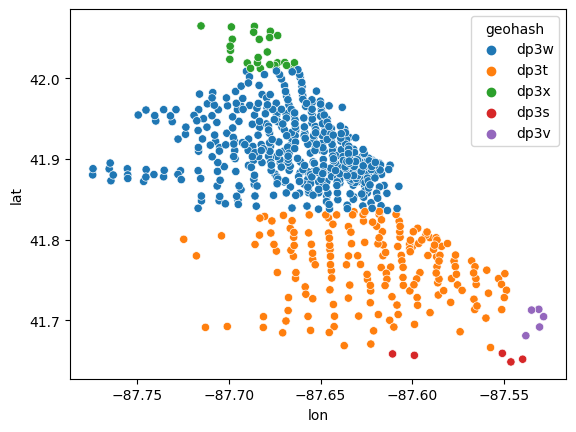

In [34]:
sns.scatterplot(x=station_df["lon"],y=station_df["lat"], hue=station_df["geohash"])

In [9]:
from divvy.interface_ui.flow.ui_utils import get_retained_geohash
import os

In [10]:
quarter= os.environ.get("DIVVY_QUARTER")
year= os.environ.get("DIVVY_YEAR")

In [11]:
import os
import pandas as pd
import numpy as np
import math

from divvy.ml_logic.data_import import get_weather_data, get_divvy_data
from divvy.ml_logic.cleaning import compute_geohash_stations,weather_cleaning, cleaning_divvy_gen,cleaning_divvy_gen_agg, merge_divvy_weather, features_target
from divvy.ml_logic.preprocessor import transform_time_features, preprocess_features, target_process

In [12]:
target_chosen="nb_arrivals"

quarter= os.environ.get("DIVVY_QUARTER")
year= os.environ.get("DIVVY_YEAR")

raw_divvy_df = get_divvy_data(year,quarter)
raw_weather_df = get_weather_data()

print("Raw data imported")

# Clean data & merge data

clean_divvy_df = cleaning_divvy_gen_agg(raw_divvy_df)
clean_weather_df = weather_cleaning(raw_weather_df)

merged_df = merge_divvy_weather(clean_divvy_df, clean_weather_df)

Raw data imported


/home/gdolle/code/G-Dolle/DIVVY_BIKE/divvy/ml_logic/cleaning.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stations_reduced.rename(columns={"name":"station_name"}, inplace=True)


In [18]:
raw_divvy_df.head(2)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,hourly_data_started,hourly_data_ended
0,9DC7B962304CBFD8,electric_bike,2021-09-28 16:07:10,2021-09-28 16:09:54,NaN,NaN,NaN,NaN,41.89,-87.68,41.89,-87.67,casual,2021-09-28 16:00:00,2021-09-28 16:00:00
1,F930E2C6872D6B32,electric_bike,2021-09-28 14:24:51,2021-09-28 14:40:05,NaN,NaN,NaN,NaN,41.94,-87.64,41.98,-87.67,casual,2021-09-28 14:00:00,2021-09-28 15:00:00


In [70]:
raw_divvy_df.rideable_type.value_counts()

classic_bike     1472226
electric_bike     772583
docked_bike       138100
Name: rideable_type, dtype: int64

In [71]:
raw_divvy_df.start_station_name.isnull().sum()

268834

In [73]:
condition = raw_divvy_df.start_station_name.isnull() == False
raw_divvy_df_filtered = raw_divvy_df[condition]

In [75]:
raw_divvy_df_filtered.head(2)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,hourly_data_started,hourly_data_ended
10,CBFE6F6DE98B37BC,electric_bike,2021-09-28 21:54:55,2021-09-28 22:02:49,Clark St & Grace St,TA1307000127,NaN,NaN,41.950956,-87.659174,41.970000,-87.650000,casual,2021-09-28 22:00:00,2021-09-28 22:00:00
59,E92C804563F261EC,classic_bike,2021-09-05 01:25:08,2021-09-05 01:35:46,Wells St & Walton St,TA1306000011,Desplaines St & Kinzie St,TA1306000003,41.899930,-87.634430,41.888716,-87.644448,casual,2021-09-05 01:00:00,2021-09-05 02:00:00


In [78]:
raw_divvy_df_filtered = raw_divvy_df_filtered.drop(columns=["end_station_name","end_station_id","ended_at", "member_casual","hourly_data_ended"], axis=1)

In [79]:
raw_divvy_df_filtered.head(2)

,ride_id,rideable_type,started_at,start_station_name,start_station_id,start_lat,start_lng,end_lat,end_lng,hourly_data_started
10,CBFE6F6DE98B37BC,electric_bike,2021-09-28 21:54:55,Clark St & Grace St,TA1307000127,41.950956,-87.659174,41.970000,-87.650000,2021-09-28 22:00:00
59,E92C804563F261EC,classic_bike,2021-09-05 01:25:08,Wells St & Walton St,TA1306000011,41.899930,-87.634430,41.888716,-87.644448,2021-09-05 01:00:00


In [80]:
raw_divvy_df_filtered['day'] = raw_divvy_df_filtered.hourly_data_started.dt.date

In [81]:
raw_divvy_df_filtered.head(2)

,ride_id,rideable_type,started_at,start_station_name,start_station_id,start_lat,start_lng,end_lat,end_lng,hourly_data_started,day
10,CBFE6F6DE98B37BC,electric_bike,2021-09-28 21:54:55,Clark St & Grace St,TA1307000127,41.950956,-87.659174,41.970000,-87.650000,2021-09-28 22:00:00,2021-09-28
59,E92C804563F261EC,classic_bike,2021-09-05 01:25:08,Wells St & Walton St,TA1306000011,41.899930,-87.634430,41.888716,-87.644448,2021-09-05 01:00:00,2021-09-05


In [93]:
raw_divvy_df_fil_red = raw_divvy_df_filtered[["day","start_station_name"]]
raw_divvy_df_fil_red["nb_rides"]=1

/tmp/ipykernel_16602/2283621079.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [94]:
test_df = raw_divvy_df_fil_red.groupby(by=["start_station_name","day"])["nb_rides"].sum().reset_index()
test_df

,start_station_name,day,nb_rides
0,2112 W Peterson Ave,2021-07-01,6
1,2112 W Peterson Ave,2021-07-02,6
2,2112 W Peterson Ave,2021-07-03,2
3,2112 W Peterson Ave,2021-07-04,6
4,2112 W Peterson Ave,2021-07-05,6
...,...,...,...
56687,Yates Blvd & 93rd St,2021-09-21,3
56688,Yates Blvd & 93rd St,2021-09-23,1
56689,Yates Blvd & 93rd St,2021-09-25,1
56690,Yates Blvd & 93rd St,2021-09-26,1


In [97]:
test_df.nb_rides.describe()

count    56692.000000
mean        37.290535
std         50.095269
min          1.000000
25%          4.000000
50%         20.000000
75%         53.000000
max       1192.000000
Name: nb_rides, dtype: float64

<AxesSubplot: xlabel='nb_rides', ylabel='Count'>

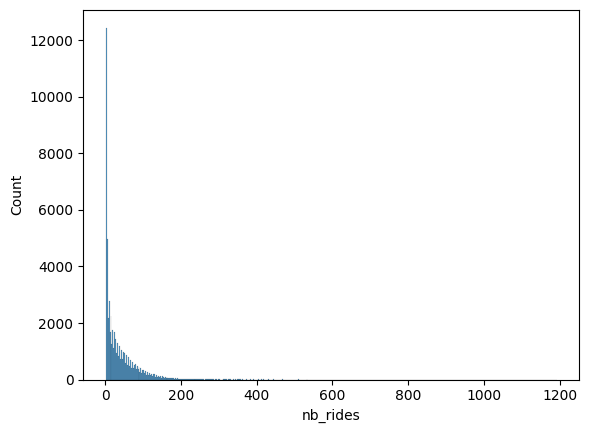

In [96]:
sns.histplot(test_df.nb_rides)

In [100]:
station_df_reduced=station_df[["name","lat","lon"]]
station_df_reduced.rename(columns={"name":"station_name"}, inplace=True)

/tmp/ipykernel_16602/3258416279.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [101]:
test_df.rename(columns={"start_station_name":"station_name"}, inplace=True)

In [103]:
merged_df = test_df.merge(station_df_reduced, how="left", on="station_name")

In [104]:
merged_df

,station_name,day,nb_rides,lat,lon
0,2112 W Peterson Ave,2021-07-01,6,41.991178,-87.683593
1,2112 W Peterson Ave,2021-07-02,6,41.991178,-87.683593
2,2112 W Peterson Ave,2021-07-03,2,41.991178,-87.683593
3,2112 W Peterson Ave,2021-07-04,6,41.991178,-87.683593
4,2112 W Peterson Ave,2021-07-05,6,41.991178,-87.683593
...,...,...,...,...,...
56687,Yates Blvd & 93rd St,2021-09-21,3,41.726166,-87.566276
56688,Yates Blvd & 93rd St,2021-09-23,1,41.726166,-87.566276
56689,Yates Blvd & 93rd St,2021-09-25,1,41.726166,-87.566276
56690,Yates Blvd & 93rd St,2021-09-26,1,41.726166,-87.566276


In [ ]:
sns.scatterplot(x=merged_df["lon"],y=merged_df["lat"], hue=merged_df["geohash"])

In [48]:
import PIL
import numpy as np

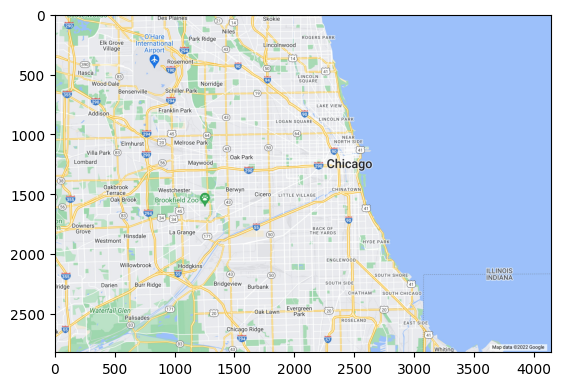

In [67]:
bounding_boxes = (-88.373455, -87.094921, 41.637692, 42.102986)

chicago_map = np.array(PIL.Image.open("raw_data/Chicago_map.png"))

plt.imshow(chicago_map);

In [68]:
def plot_on_map(df, BB, chicago_map, s=10, alpha=0.2):
    plt.figure(figsize=(16,10))

    plt.scatter(df.lon, df.lat, zorder=1, alpha=alpha, c='red', s=s)
    plt.xlim((BB[0], BB[1]))
    plt.ylim((BB[2], BB[3]))
    plt.title('Pickup locations')
    plt.imshow(chicago_map, zorder=0, extent=BB)



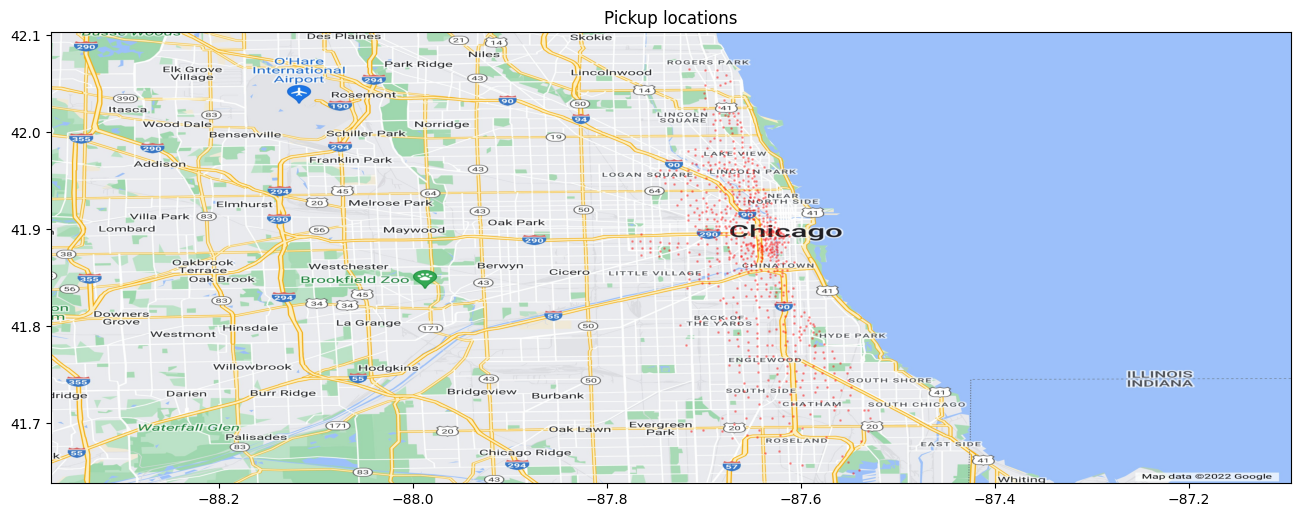

In [69]:
plot_on_map(station_df, bounding_boxes, chicago_map, s=1, alpha=0.3)

# Descriptive stats on the front end?

In [106]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 14.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 14.3 MB/s eta 0:00:0000:0100:01
  Using cached validators-0.20.0.tar.gz (30 kB)
  Preparing metadata (setup.py) ... done
  Using cached typing_extensions-4.4.0-py3-none-any.whl (26 kB)
  Using cached importlib_metadata-5.1.0-py3-none-any.whl (21 kB)
  Using cached click-8.1.3-py3-none-any.whl (96 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 13.4 MB/s eta 0:00:00
  Using cached GitPython-3.1.29-py3-none-any.whl (182 kB)
  Using cached semver-2.13.0-py2.py3-none-any.whl (12 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.2 MB/s eta 0:00:00a 0:00:01
  Using cached tzlocal-4.2-py3-none-any.whl (19 kB)
  Using cached pyarrow-10.0.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (35.9 MB)
  Using cached blinker-1.5-py2.py3-none-any.whl (12 kB)
  Using cached rich-12.6.0-py3-none-any.whl (237 kB)
  Using 

In [125]:
station_df = get_station_data()

capacity_df = station_df[['capacity']]
capacity_df=capacity_df.drop_duplicates().reset_index(drop=True)
capacity_df

,capacity
0,11
1,7
2,19
3,15
4,31
5,23
6,27
7,35
8,47
9,39


In [131]:
capacity_df = capacity_df.sort_values(by="capacity",ascending=True)
capacity_df = capacity_df[capacity_df["capacity"]>0]
capacity_df = capacity_df.reset_index(drop=True).drop(columns="index")
capacity_df

,capacity
0,1
1,2
2,3
3,4
4,5
5,6
6,7
7,8
8,9
9,10


In [133]:
station_df = get_station_data()

capacity_df = station_df[['capacity']]
capacity_df=capacity_df.drop_duplicates().reset_index(drop=True)
capacity_df = capacity_df.sort_values(by="capacity",ascending=True)
capacity_df = capacity_df[capacity_df["capacity"]>0]
#capacity_df = capacity_df.reset_index(drop=True).drop(columns="index")
capacity_df


,capacity
17,1
20,2
23,3
25,4
19,5
21,6
1,7
24,8
18,9
22,10


In [134]:
df = pd.DataFrame(
    np.random.randn(1000, 2) / [50, 50] + [37.76, -122.4],
    columns=['lat', 'lon'])
df

,lat,lon
0,37.765057,-122.378862
1,37.787195,-122.416014
2,37.772380,-122.405181
3,37.768669,-122.387474
4,37.765457,-122.434709
...,...,...
995,37.725891,-122.377790
996,37.786766,-122.390091
997,37.730169,-122.405161
998,37.779317,-122.416989


In [135]:
import datetime

# given date
x_date = datetime.date(2022, 12, 14)
no = x_date.weekday()

if no < 5:
    print("Date is Weekday")
else:  # 5 Sat, 6 Sun
    print("Date is Weekend")

Date is Weekday


In [136]:
no

2

# Weather and number of rides

In [3]:
pwd

'/home/gdolle/code/G-Dolle/DIVVY_BIKE/notebooks'

In [4]:
cd '/home/gdolle/code/G-Dolle/DIVVY_BIKE'

/home/gdolle/code/G-Dolle/DIVVY_BIKE


In [5]:
import os
import pandas as pd
import numpy as np
import math

from divvy.ml_logic.data_import import get_weather_data, get_divvy_data
from divvy.ml_logic.cleaning import compute_geohash_stations,weather_cleaning, cleaning_divvy_gen,cleaning_divvy_gen_agg, merge_divvy_weather, features_target
from divvy.ml_logic.preprocessor import transform_time_features, preprocess_features, target_process

In [6]:
target_chosen="nb_arrivals"

quarter= os.environ.get("DIVVY_QUARTER")
year= os.environ.get("DIVVY_YEAR")

raw_divvy_df = get_divvy_data(year,quarter)
raw_weather_df = get_weather_data()

print("Raw data imported")

# Clean data & merge data

clean_divvy_df = cleaning_divvy_gen_agg(raw_divvy_df)
clean_weather_df = weather_cleaning(raw_weather_df)

merged_df = merge_divvy_weather(clean_divvy_df, clean_weather_df)

Raw data imported


/home/gdolle/code/G-Dolle/DIVVY_BIKE/divvy/ml_logic/cleaning.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stations_reduced.rename(columns={"name":"station_name"}, inplace=True)


In [7]:
merged_df.shape

(52546, 12)

In [8]:
merged_df.geohash.nunique()

44

In [138]:
merged_df.head(2)

,geohash,hourly_data,nb_departures,nb_arrivals,ratio,dt_iso,temp,pressure,humidity,wind_speed,wind_deg,clouds_all
0,dp3s,2021-07-01 04:00:00,1.0,1.0,1.0,2021-07-01 04:00:00,21.29,1001,84,0.0,0,75
1,dp3s,2021-07-01 17:00:00,1.0,0.0,inf,2021-07-01 17:00:00,23.18,1018,62,7.2,20,20


In [9]:
nb_rides_geohash_df = merged_df.groupby(by=["geohash",
                                            "hourly_data"])["nb_departures",
                                                            "nb_arrivals"].sum().reset_index()
nb_rides_geohash_df.head(2)

/tmp/ipykernel_1555/2731720380.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  nb_rides_geohash_df = merged_df.groupby(by=["geohash",


,geohash,hourly_data,nb_departures,nb_arrivals
0,dp3sy,2021-07-01 04:00:00,1.0,1.0
1,dp3sy,2021-07-01 17:00:00,1.0,0.0


In [10]:
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates

In [ ]:
condition_1 = nb_rides_geohash_df["hourly_data"] >= pd.to_datetime("2021-07-01")
condition_2 = nb_rides_geohash_df["hourly_data"] <= pd.to_datetime("2021-08-01")

In [27]:
def timeframe_df(df,start_time,end_time):
    
    condition_1 = df["hourly_data"] >= pd.to_datetime(start_time)
    condition_2 = df["hourly_data"] <= pd.to_datetime(end_time)

    df_red = df[condition_1]
    df_red = df_red[condition_2]
    
    return df_red
    

In [32]:
def plot_rides(start_time,end_time,df_divvy,df_weather,geohash):
    
    df_divvy_red = timeframe_df(df_divvy,start_time,end_time)
    df_weather_red = timeframe_df(df_weather,start_time,end_time)
    
    df_divvy_red = df_divvy_red[df_divvy_red["geohash"]==geohash]


    fig, ax1 = plt.subplots()

    ax2 = ax1.twinx()
    ax1.plot(df_divvy_red["hourly_data"],df_divvy_red.nb_departures, 'g-')
    ax2.plot(df_weather_red["hourly_data"],df_weather_red.temp, 'b-')

    ax1.set_xlabel('Time')
    ax1.set_ylabel('nb departures per hour', color='g')
    ax2.set_ylabel('Temperature (°C)', color='b')

    plt.show()


/tmp/ipykernel_1555/1035725473.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_red = df_red[condition_2]


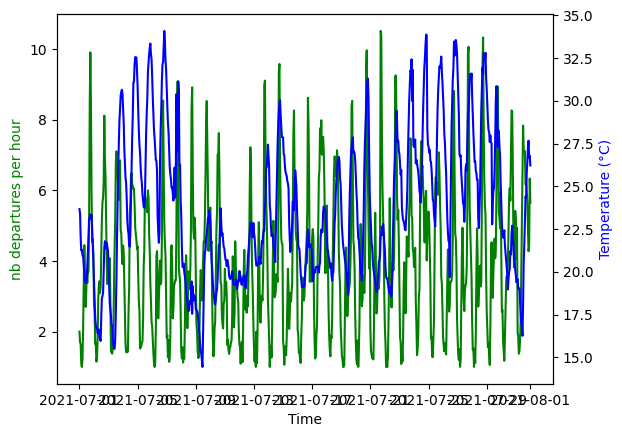

In [35]:
start_time = "2021-07-01"
end_time = "2021-08-01"
geohash = "dp3wm"

plot_rides(start_time,end_time,nb_rides_geohash_df,clean_weather_df,geohash)

In [25]:
clean_weather_df.head(2)

,dt_iso,temp,pressure,humidity,wind_speed,wind_deg,clouds_all,hourly_data
0,2013-01-01 00:00:00,-2.87,1018,68,4.12,300,100,2013-01-01 00:00:00
1,2013-01-01 01:00:00,-3.12,1019,69,3.10,310,100,2013-01-01 01:00:00


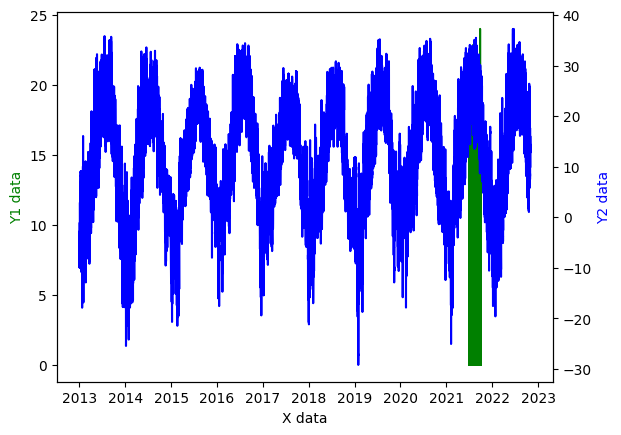

In [26]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(nb_rides_geohash_df["hourly_data"],nb_rides_geohash_df.nb_departures, 'g-')
ax2.plot(clean_weather_df["hourly_data"],clean_weather_df.temp, 'b-')

ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data', color='g')
ax2.set_ylabel('Y2 data', color='b')

plt.show()

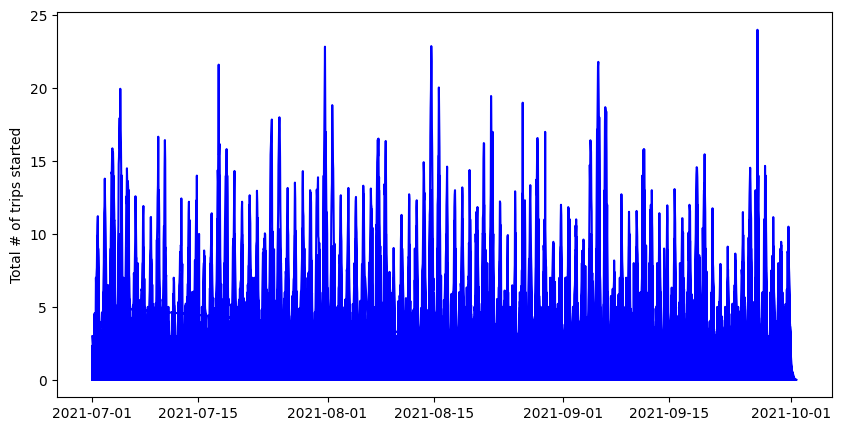

In [16]:
plt.figure(figsize=(10, 5))
plt.xlabel('') 
plt.ylabel('Total # of trips started')
plt.plot(nb_rides_geohash_df["hourly_data"], nb_rides_geohash_df.nb_departures,
         color='b')

'''
plt.xaxis.set(
    major_locator=mdates.DayLocator(),
    major_formatter=mdates.DateFormatter("\n\n%A"),
    minor_locator=mdates.HourLocator((0, 12)),
    minor_formatter=mdates.DateFormatter("%H"),
)'''
plt.show()

In [ ]:
condition = raw_divvy_df.start_station_name.isnull() == False
raw_divvy_df_filtered = raw_divvy_df[condition]
raw_divvy_df_filtered = raw_divvy_df_filtered.drop(columns=["end_station_name","end_station_id","ended_at", "member_casual","hourly_data_ended"], axis=1)
raw_divvy_df_filtered['day'] = raw_divvy_df_filtered.hourly_data_started.dt.date

In [ ]:
raw_divvy_df_fil_red = raw_divvy_df_filtered[["day","start_station_name"]]
raw_divvy_df_fil_red["nb_rides"]=1

In [36]:
raw_divvy_df = get_divvy_data(year,quarter)
raw_divvy_df.head(3)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,9DC7B962304CBFD8,electric_bike,2021-09-28 16:07:10,2021-09-28 16:09:54,NaN,NaN,NaN,NaN,41.89,-87.68,41.89,-87.67,casual
1,F930E2C6872D6B32,electric_bike,2021-09-28 14:24:51,2021-09-28 14:40:05,NaN,NaN,NaN,NaN,41.94,-87.64,41.98,-87.67,casual
2,6EF72137900BB910,electric_bike,2021-09-28 00:20:16,2021-09-28 00:23:57,NaN,NaN,NaN,NaN,41.81,-87.72,41.80,-87.72,casual


In [86]:
divvy_q1_2021 = get_divvy_data(2021,"Q1")

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x91 in position 10: invalid start byte

In [87]:
divvy_q2_2021 = get_divvy_data(2021,"Q2")
divvy_q3_2021 = get_divvy_data(2021,"Q3")
divvy_q4_2021 = get_divvy_data(2021,"Q4")


In [88]:
divvy_2021_df = pd.concat([divvy_q2_2021, divvy_q3_2021,divvy_q4_2021])

In [89]:
rides_df = divvy_2021_df.copy()

In [90]:
#rides_df = raw_divvy_df.copy()

rides_df = rides_df[rides_df["start_station_name"].isnull()==False]
rides_df['started_at']=pd.to_datetime(rides_df['started_at'])
rides_df['hourly_data_started'] = rides_df.started_at.dt.round('60min')

rides_df = rides_df[["start_station_name","ride_id","hourly_data_started"]]
rides_df.rename(columns={"start_station_name":"station_name"}, inplace=True)

rides_df.head(3)

,station_name,ride_id,hourly_data_started
0,State St & Pearson St,6C992BD37A98A63F,2021-04-12 18:00:00
1,Dorchester Ave & 49th St,1E0145613A209000,2021-04-27 17:00:00
2,Loomis Blvd & 84th St,E498E15508A80BAD,2021-04-03 13:00:00


In [91]:
precision_level= int(os.environ.get("PRECISION_LEVEL"))
geohash_station_df = compute_geohash_stations(precision = precision_level)


/home/gdolle/code/G-Dolle/DIVVY_BIKE/divvy/ml_logic/cleaning.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stations_reduced.rename(columns={"name":"station_name"}, inplace=True)


In [92]:
rides_df = rides_df.merge(geohash_station_df, on="station_name", how="left")

In [93]:
rides_df["date"]= pd.to_datetime(rides_df["hourly_data_started"]).dt.date

In [94]:
rides_df.shape

(4556821, 5)

In [95]:
rides_df["nb_rides"]=1
rides_df.head(5)

,station_name,ride_id,hourly_data_started,geohash,date,nb_rides
0,State St & Pearson St,6C992BD37A98A63F,2021-04-12 18:00:00,dp3wm,2021-04-12,1
1,Dorchester Ave & 49th St,1E0145613A209000,2021-04-27 17:00:00,dp3ty,2021-04-27,1
2,Loomis Blvd & 84th St,E498E15508A80BAD,2021-04-03 13:00:00,dp3tm,2021-04-03,1
3,Honore St & Division St,1887262AD101C604,2021-04-17 09:00:00,dp3wk,2021-04-17,1
4,Loomis Blvd & 84th St,C123548CAB2A32A5,2021-04-03 13:00:00,dp3tm,2021-04-03,1


In [96]:
rides_df_daily = rides_df.groupby(by=["geohash","date"])["nb_rides"].sum().reset_index()
rides_df_daily.head(5)

,geohash,date,nb_rides
0,dp3sy,2021-04-04,1
1,dp3sy,2021-04-06,1
2,dp3sy,2021-04-07,1
3,dp3sy,2021-04-10,2
4,dp3sy,2021-04-18,1


In [97]:
clean_weather_df["date"]= pd.to_datetime(clean_weather_df["hourly_data"]).dt.date
clean_weather_df.head(5)

,dt_iso,temp,pressure,humidity,wind_speed,wind_deg,clouds_all,hourly_data,date
0,2013-01-01 00:00:00,-2.87,1018,68,4.12,300,100,2013-01-01 00:00:00,2013-01-01
1,2013-01-01 01:00:00,-3.12,1019,69,3.10,310,100,2013-01-01 01:00:00,2013-01-01
2,2013-01-01 02:00:00,-3.12,1019,69,2.60,290,100,2013-01-01 02:00:00,2013-01-01
3,2013-01-01 03:00:00,-2.87,1019,66,4.12,360,100,2013-01-01 03:00:00,2013-01-01
4,2013-01-01 04:00:00,-4.17,1020,64,5.70,330,100,2013-01-01 04:00:00,2013-01-01


In [98]:
avg_temp_df = clean_weather_df.groupby(by=["date"])["temp"].mean().reset_index()
avg_temp_df.head(5)

,date,temp
0,2013-01-01,-5.561667
1,2013-01-02,-6.889583
2,2013-01-03,-3.463750
3,2013-01-04,-4.640833
4,2013-01-05,-1.201250


In [99]:
def timeframe_df(df,timevariable,start_time,end_time):
    
    condition_1 = df[timevariable] >= pd.to_datetime(start_time)
    condition_2 = df[timevariable] <= pd.to_datetime(end_time)

    df_red = df[condition_1]
    df_red = df_red[condition_2]
    
    return df_red

In [100]:
def plot_rides(start_time,end_time,df_divvy,df_weather,timevariable,geohash):
    
    df_divvy_red = timeframe_df(df_divvy,timevariable,start_time,end_time)
    df_weather_red = timeframe_df(df_weather,timevariable,start_time,end_time)
    
    df_divvy_red = df_divvy_red[df_divvy_red["geohash"]==geohash]


    fig, ax1 = plt.subplots()

    ax2 = ax1.twinx()
    ax1.plot(df_divvy_red[timevariable],df_divvy_red.nb_rides, 'g-')
    ax2.plot(df_weather_red[timevariable],df_weather_red.temp, 'b-')

    ax1.set_xlabel('Time')
    ax1.set_ylabel('Average nb of courses per day', color='g')
    ax2.set_ylabel('Temperature (°C)', color='b')

    plt.show()

In [101]:
start_time = "2021-07-01"
end_time = "2021-12-31"
timevariable="date"
geohash = "dp3wm"

/tmp/ipykernel_1555/3644348959.py:3: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  condition_1 = df[timevariable] >= pd.to_datetime(start_time)
/tmp/ipykernel_1555/3644348959.py:4: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  condition_2 = df[timevariable] <= pd.to_datetime(end_time)
/tmp/ipykernel_1555/3644348959.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_red = df_red[condition_2]


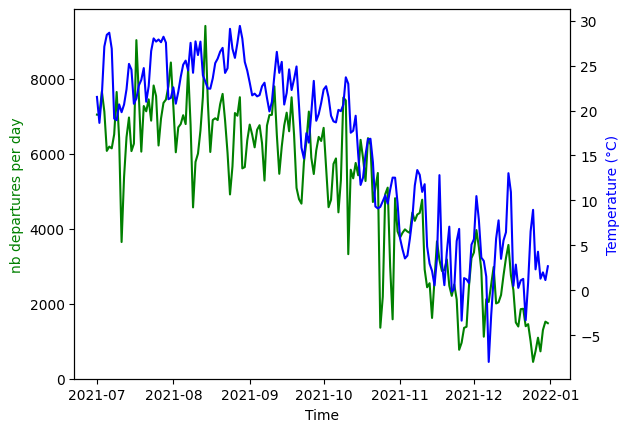

In [102]:
plot_rides(start_time,end_time,rides_df_daily,avg_temp_df,timevariable,geohash)

In [103]:
rides_df_daily.to_csv("raw_data/rides_df_daily_2021.csv", index=False)
avg_temp_df.to_csv("raw_data/avg_temp.csv", index=False)

In [109]:
rides_df_daily=pd.read_csv("raw_data/rides_df_daily_2021.csv")
rides_df_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10166 entries, 0 to 10165
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   geohash   10166 non-null  object
 1   date      10166 non-null  object
 2   nb_rides  10166 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 238.4+ KB


In [110]:
rides_df_daily.head(3)

,geohash,date,nb_rides
0,dp3sy,2021-04-04,1
1,dp3sy,2021-04-06,1
2,dp3sy,2021-04-07,1


In [111]:
rides_df_daily["date"]= pd.to_datetime(rides_df_daily["date"])
rides_df_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10166 entries, 0 to 10165
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   geohash   10166 non-null  object        
 1   date      10166 non-null  datetime64[ns]
 2   nb_rides  10166 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 238.4+ KB


In [112]:
avg_temp_df=pd.read_csv("raw_data/avg_temp.csv")
avg_temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3591 entries, 0 to 3590
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    3591 non-null   object 
 1   temp    3591 non-null   float64
dtypes: float64(1), object(1)
memory usage: 56.2+ KB


In [113]:
avg_temp_df["date"]= pd.to_datetime(avg_temp_df["date"])
avg_temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3591 entries, 0 to 3590
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3591 non-null   datetime64[ns]
 1   temp    3591 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 56.2 KB


: 